In [1]:
%pylab inline

import cvxpy
from cvxpy import Variable, Minimize, sum_squares, norm, Problem, Parameter, mul_elemwise, sum_entries, Constant
from scipy import sparse
import sys, argparse
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys

sys.path.append('../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from joblib import Parallel, delayed
import multiprocessing

def read_data(filename):

    # read the boundary points and get a mask
    raw_data = np.loadtxt(filename,skiprows=0)
    coords = raw_data[:,:2]
    deflection = raw_data[:,2]
    boundary = raw_data[:,3]
    return  coords, deflection, boundary


Populating the interactive namespace from numpy and matplotlib


In [2]:
CUTOFF  = 8
N_SOLUTIONS = 24
gamma_vals = np.logspace(-5, 0, N_SOLUTIONS)


coords, deflection, boundary = read_data('../../tractionforce/data/t2.txt')
x_obs_positions = sorted(set(coords[:, 0]))
y_obs_positions = sorted(set(coords[:, 1]))

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

N = len(x_obs_positions)
M = len(y_obs_positions)

boundary2d = boundary.reshape((N, M))
mask = np.zeros(boundary2d.shape)
for r in range(boundary2d.shape[1]):
    pts = np.where(boundary2d[:, r] == 1)
    
    if (len(pts[0]) > 0):
        mini = (min(min(pts)))
        maxi = max(max(pts))
        mask[ mini:maxi, r] = 1

distances2d = -ndimage.distance_transform_edt(mask) + ndimage.distance_transform_edt(1 - mask)
distances2d = distances2d.flatten()

condition_inside = distances2d<=0
condition_outside = (distances2d>0) * (distances2d<=CUTOFF)

del distances2d, mask, boundary2d
gc.collect()

x_out = np.array(coords[condition_outside,0]/dx,dtype=int)
y_out = np.array(coords[condition_outside,1]/dy,dtype=int)

x_in = np.array(coords[condition_inside,0]/dx,dtype=int)
y_in = np.array(coords[condition_inside,1]/dy,dtype=int)

x_center = np.mean(x_in)
y_center = np.mean(y_in)

u_x_in = deflection[condition_inside]
u_x_out = deflection[condition_outside]

n_in = len(x_in)
n_out = len(x_out)

print("Size of the problem is " + str( n_in + n_out))

deltax_in_in = x_in[...,np.newaxis] - x_in[np.newaxis, ...]  # should be x-x'
deltax_out_in = x_out[...,np.newaxis] - x_in[np.newaxis, ...]  # should be x-x'
deltay_in_in = y_in[...,np.newaxis] - y_in[np.newaxis, ...]  # y - y'
deltay_out_in = y_out[...,np.newaxis] - y_in[np.newaxis,...] # y - y'

l2_in_plus_in_plus = (np.array([deltax_in_in*dx - dx/2.0, deltay_in_in*dy - dy/2.0])**2).sum(axis=0)**0.5
l2_in_plus_in_minus = (np.array([deltax_in_in*dx - dx/2.0, deltay_in_in*dy + dy/2.0])**2).sum(axis=0)**0.5
l2_in_minus_in_plus = (np.array([deltax_in_in*dx + dx/2.0, deltay_in_in*dy - dy/2.0])**2).sum(axis=0)**0.5
l2_in_minus_in_minus = (np.array([deltax_in_in*dx + dx/2.0, deltay_in_in*dy+ dy/2.0]) ** 2).sum(axis=0) ** 0.5

l2_out_plus_in_plus = (np.array([deltax_out_in*dx - dx/2.0, deltay_out_in*dy - dy/2.0])**2).sum(axis=0)**0.5
l2_out_plus_in_minus = (np.array([deltax_out_in*dx - dx/2.0, deltay_out_in*dy + dy/2.0])**2).sum(axis=0)**0.5
l2_out_minus_in_plus = (np.array([deltax_out_in*dx + dx/2.0, deltay_out_in*dy - dy/2.0])**2).sum(axis=0)**0.5
l2_out_minus_in_minus = (np.array([deltax_out_in*dx + dx/2.0, deltay_out_in*dy + dy/2.0]) ** 2).sum(axis=0) ** 0.5

x_adjacency = sparse.csr_matrix((deltax_in_in == -1)*(deltay_in_in == 0)*-1 + (deltax_in_in == 1)*(deltay_in_in == 0)*1)
y_adjacency = sparse.csr_matrix((deltay_in_in == -1)*(deltax_in_in == 0)*-1 + (deltay_in_in == 1)*(deltax_in_in == 0)*1)

A_in_in = fxx(deltax_in_in*dx-dx/2. , deltay_in_in*dy-dy/2.0 , l2_in_plus_in_plus) - \
          fxx(deltax_in_in*dx-dx/2. , deltay_in_in*dy+dy/2.0, l2_in_plus_in_minus) -\
          fxx(deltax_in_in*dx+dx/2. , deltay_in_in*dy-dy/2.0, l2_in_minus_in_plus) + \
          fxx(deltax_in_in*dx+dx/2. , deltay_in_in*dy+dy/2.0, l2_in_minus_in_minus)

A_out_in = fxx(deltax_out_in*dx-dx/2. , deltay_out_in*dy-dy/2.0 , l2_out_plus_in_plus) - \
          fxx(deltax_out_in*dx-dx/2. , deltay_out_in*dy+dy/2.0, l2_out_plus_in_minus) -\
          fxx(deltax_out_in*dx+dx/2. , deltay_out_in*dy-dy/2.0, l2_out_minus_in_plus) + \
          fxx(deltax_out_in*dx+dx/2. , deltay_out_in*dy+dy/2.0, l2_out_minus_in_minus)

D_in_in = fxy(deltax_in_in*dx-dx/2. , deltay_in_in*dy-dy/2.0 , l2_in_plus_in_plus) - \
          fxy(deltax_in_in*dx-dx/2. , deltay_in_in*dy+dy/2.0, l2_in_plus_in_minus) - \
          fxy(deltax_in_in*dx+dx/2. , deltay_in_in*dy-dy/2.0, l2_in_minus_in_plus) + \
          fxy(deltax_in_in*dx+dx/2. , deltay_in_in*dy+dy/2.0, l2_in_minus_in_minus)

D_out_in = fxy(deltax_out_in*dx-dx/2. , deltay_out_in*dy-dy/2.0 , l2_out_plus_in_plus) - \
           fxy(deltax_out_in*dx-dx/2. , deltay_out_in*dy+dy/2.0, l2_out_plus_in_minus) - \
           fxy(deltax_out_in*dx+dx/2. , deltay_out_in*dy-dy/2.0, l2_out_minus_in_plus) + \
           fxy(deltax_out_in*dx+dx/2. , deltay_out_in*dy+dy/2.0, l2_out_minus_in_minus)

B_in_in = x_in[..., np.newaxis]*A_in_in - fxxx(deltax_in_in-dx/2. , deltay_in_in-dy/2.0 , l2_in_plus_in_plus) + \
              fxxx(deltax_in_in-dx/2. , deltay_in_in+dy/2.0, l2_in_plus_in_minus) +\
              fxxx(deltax_in_in+dx/2. , deltay_in_in-dy/2.0, l2_in_minus_in_plus) - \
              fxxx(deltax_in_in+dx/2. , deltay_in_in+dy/2.0, l2_in_minus_in_minus)

B_out_in = x_out[..., np.newaxis]*A_out_in - fxxx(deltax_out_in-dx/2. , deltay_out_in-dy/2.0 , l2_out_plus_in_plus) + \
          fxxx(deltax_out_in-dx/2. , deltay_out_in+dy/2.0, l2_out_plus_in_minus) +\
          fxxx(deltax_out_in+dx/2. , deltay_out_in-dy/2.0, l2_out_minus_in_plus) - \
          fxxx(deltax_out_in+dx/2. , deltay_out_in+dy/2.0, l2_out_minus_in_minus)

C_in_in = y_in[..., np.newaxis]*A_in_in - fxxy(deltax_in_in-dx/2. , deltay_in_in-dy/2.0 , l2_in_plus_in_plus) + \
          fxxy(deltax_in_in-dx/2. , deltay_in_in+dy/2.0, l2_in_plus_in_minus) + \
          fxxy(deltax_in_in+dx/2. , deltay_in_in-dy/2.0, l2_in_minus_in_plus) - \
          fxxy(deltax_in_in+dx/2. , deltay_in_in+dy/2.0, l2_in_minus_in_minus)

C_out_in = y_out[..., np.newaxis]*A_out_in - fxxy(deltax_out_in-dx/2. , deltay_out_in-dy/2.0 , l2_out_plus_in_plus) + \
           fxxy(deltax_out_in-dx/2. , deltay_out_in+dy/2.0, l2_out_plus_in_minus) + \
           fxxy(deltax_out_in+dx/2. , deltay_out_in-dy/2.0, l2_out_minus_in_plus) - \
           fxxy(deltax_out_in+dx/2. , deltay_out_in+dy/2.0, l2_out_minus_in_minus)

E_in_in = x_in[..., np.newaxis] * D_in_in - fxyx(deltax_in_in - dx / 2., deltay_in_in - dy / 2.0,
                                                 l2_in_plus_in_plus) + \
          fxyx(deltax_in_in - dx / 2., deltay_in_in + dy / 2.0, l2_in_plus_in_minus) + \
          fxyx(deltax_in_in + dx / 2., deltay_in_in - dy / 2.0, l2_in_minus_in_plus) - \
          fxyx(deltax_in_in + dx / 2., deltay_in_in + dy / 2.0, l2_in_minus_in_minus)

E_out_in = x_out[..., np.newaxis] * D_out_in - fxyx(deltax_out_in - dx / 2., deltay_out_in - dy / 2.0,
                                                   l2_out_plus_in_plus) + \
           fxyx(deltax_out_in - dx / 2., deltay_out_in + dy / 2.0, l2_out_plus_in_minus) + \
           fxyx(deltax_out_in + dx / 2., deltay_out_in - dy / 2.0, l2_out_minus_in_plus) - \
           fxyx(deltax_out_in + dx / 2., deltay_out_in + dy / 2.0, l2_out_minus_in_minus)

F_in_in = y_in[..., np.newaxis]*D_in_in - fxyx(deltax_in_in-dx/2. , deltay_in_in-dy/2.0 , l2_in_plus_in_plus) + \
          fxyx(deltax_in_in-dx/2. , deltay_in_in+dy/2.0, l2_in_plus_in_minus) + \
          fxyx(deltax_in_in+dx/2. , deltay_in_in-dy/2.0, l2_in_minus_in_plus) - \
          fxyx(deltax_in_in+dx/2. , deltay_in_in+dy/2.0, l2_in_minus_in_minus)

F_out_in = y_out[..., np.newaxis]* D_out_in - fxyx(deltax_out_in-dx/2. , deltay_out_in-dy/2.0 , l2_out_plus_in_plus) + \
           fxyx(deltax_out_in-dx/2. , deltay_out_in+dy/2.0, l2_out_plus_in_minus) + \
           fxyx(deltax_out_in+dx/2. , deltay_out_in-dy/2.0, l2_out_minus_in_plus) - \
           fxyx(deltax_out_in+dx/2. , deltay_out_in+dy/2.0, l2_out_minus_in_minus)

# make derivative matrices Lx Ly

Dx = sparse.csr_matrix((deltax_in_in == 0)*(deltay_in_in == 0)*-1 + (deltax_in_in == 1)*(deltay_in_in == 0)*1)
rowsums = np.squeeze(np.asarray((Dx.sum(axis=1) != 0)))
Dx[rowsums,:] = 0
Dx.eliminate_zeros()
Dx = Constant(Dx)

Dy = sparse.csr_matrix(
    (deltay_in_in == 0) * (deltax_in_in == 0) * -1 + (deltay_in_in == 1) * (deltax_in_in == 0) * 1)
rowsums = np.squeeze(np.asarray((Dy.sum(axis=1) != 0)))
Dy[rowsums,:] = 0
Dy.eliminate_zeros()
Dy = Constant(Dy)

del deltax_in_in, deltay_in_in, deltax_out_in, deltay_out_in
del l2_in_plus_in_plus, l2_in_plus_in_minus, l2_in_minus_in_plus, l2_in_minus_in_minus
del l2_out_plus_in_plus, l2_out_plus_in_minus, l2_out_minus_in_plus, l2_out_minus_in_minus
gc.collect()

gamma = Parameter(sign="positive",value=1)

sigma_xz = Variable(n_in)
sigma_yz = Variable(n_in)
# predicted_in = A_in_in*sigma_xz + D_in_in*sigma_yz # add higher order terms
predicted_in = (A_in_in + B_in_in + C_in_in )*1e-3* sigma_xz + (D_in_in + E_in_in + F_in_in )*1e-3* sigma_yz
# predicted_out =  A_out_in*sigma_xz + D_out_in*sigma_yz
predicted_out = (A_out_in + B_out_in + C_out_in)*1e-3* sigma_xz + (D_out_in + E_out_in + F_out_in)*1e-3* sigma_yz


error = sum_squares(u_x_in - predicted_in) + sum_squares(u_x_out - predicted_out)

forceconstraints = [sum_entries(sigma_xz)==0, sum_entries(sigma_yz)==0] # add torque-free constraint here
net_torque = sum_entries(mul_elemwise(x_in-x_center,sigma_yz) - mul_elemwise(y_in-y_center,sigma_xz))

torqueconstraints = [net_torque == 0]

constraints = forceconstraints + torqueconstraints

Size of the problem is 2196


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


$$
\int_\Omega \left(\vert \sigma_{xz} \vert + \vert \sigma_{yz} \vert \right) \mathrm{d}\mathbf{x} 
$$

In [3]:
regularity_penalty = norm(sigma_xz,p=1)+norm(sigma_yz,p=1)
objective = Minimize(error + gamma*regularity_penalty)
prob = Problem(objective, constraints)

sq_penalty = []
l1_penalty = []
sigma_xz_values = []
sigma_yz_values = []

u_x_values = []


In [4]:
num_cores = multiprocessing.cpu_count()

def invert_one(val):
    gamma.value = val
    try:
        prob.solve(verbose= True, #max_iters = 50,
                   warm_start=True, solver = cvxpy.CVXOPT,
                   feastol = 1e-6, reltol = 1e-5,
                   abstol = 1e-6
                  )

    except cvxpy.SolverError:
        return None

    force = np.zeros_like(coords)
    force[condition_inside,0] = sigma_xz.value.reshape((n_in,))
    force[condition_inside,1] = sigma_yz.value.reshape((n_in,))

    u_x = np.zeros(coords.shape[0])
    u_x[condition_inside] = predicted_in.value
    u_x[condition_outside] = predicted_out.value
    #u_x_values.append(u_x)

    return force, u_x, error.value, regularity_penalty.value, val


results = Parallel(n_jobs=num_cores)(delayed(invert_one)(val) for val in gamma_vals)
results = [res for res in results if res is not None]

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  5e+03  3e+01  7e+01  1e+00
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  5e+03  3e+01  7e+01  1e+00
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  7e+03  3e+01  2e+00  1e+00
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  5e+03  3e+01  7e+01  1e+00
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  5e+03  3e+01  7e+01  1e+00
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  5e+03  3e+01  6e+01  1e+00
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  5e+03  3e+01  7e+01  1e+00
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  6e+03  3e+01  3e+00  1e+00
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  5e+03  3e+01  7e+01  1e+00
     pcost

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


 7:  9.6174e-02  9.6735e-02  2e-02  2e-02  4e-02  3e-03
 7:  2.9233e-01  2.9238e-01  6e-03  1e-03  2e-03  2e-04
 7:  4.5539e-02  4.5252e-02  2e-02  7e-03  1e-02  4e-04
 7:  6.4152e-02  6.3690e-02  3e-02  3e-02  6e-02  2e-03
 7:  7.3437e-02  7.6293e-02  1e-01  1e-01  2e-01  1e-02
 7:  5.0322e-02  4.9762e-02  5e-02  2e-02  3e-02  1e-03
 8:  4.3555e-02  4.3411e-02  1e-02  4e-03  9e-03  3e-04
 8:  4.4869e-01  4.4869e-01  1e-03  1e-05  9e-07  2e-06
 8:  4.2000e-02  4.1747e-02  3e-02  3e-03  7e-03  8e-05
 8:  5.4990e-02  5.4489e-02  3e-02  2e-02  4e-02  1e-03
 8:  1.1953e-01  1.1948e-01  1e-03  8e-04  2e-03  3e-05
 8:  4.2766e-02  4.2588e-02  2e-02  4e-03  9e-03  2e-04
 8:  4.4870e-01  4.4870e-01  1e-07  3e-09  3e-10  1e-08
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


 8:  5.0548e-02  5.0417e-02  2e-02  1e-02  3e-02  1e-03
 8:  4.3138e-02  4.2759e-02  4e-02  5e-03  1e-02  1e-04
 8:  3.8244e-01  3.8245e-01  5e-04  7e-05  5e-05  1e-05
 8:  4.4869e-01  4.4869e-01  1e-04  6e-06  2e-06  3e-06
 8:  1.5797e-01  1.5794e-01  2e-03  1e-03  2e-03  7e-05
 8:  8.0248e-02  8.2044e-02  3e-02  3e-02  8e-02  5e-03
 8:  2.1472e-01  2.1469e-01  3e-03  1e-03  2e-03  9e-05
 9:  4.0105e-02  3.9996e-02  2e-02  2e-03  4e-03  6e-05
 8:  4.4367e-01  4.4380e-01  3e-03  3e-04  1e-04  2e-04
 8:  5.7560e-02  5.6681e-02  1e-02  1e-02  3e-02  4e-04
 8:  9.5078e-02  9.5126e-02  8e-03  8e-03  2e-02  8e-04
 8:  6.4315e-02  6.3769e-02  3e-02  3e-02  6e-02  2e-03
 8:  2.9252e-01  2.9252e-01  2e-03  5e-04  5e-04  5e-05
 8:  4.5108e-02  4.4834e-02  2e-02  6e-03  1e-02  3e-04
 8:  7.2010e-02  7.3052e-02  6e-02  6e-02  1e-01  7e-03
 8:  4.7262e-02  4.6908e-02  1e-02  7e-03  1e-02  3e-04
 9:  4.2367e-02  4.2298e-02  5e-03  2e-03  4e-03  1e-04
 9:  4.4870e-01  4.4870e-01  2e-05  3e-07  2e-08

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


 9:  8.0651e-02  8.1803e-02  3e-02  3e-02  7e-02  4e-03
 9:  2.1467e-01  2.1466e-01  9e-04  3e-04  5e-04  2e-05
10:  3.9197e-02  3.9138e-02  1e-02  8e-04  2e-03  2e-05
 9:  4.4391e-01  4.4392e-01  4e-04  4e-05  2e-05  2e-05
 9:  5.7932e-02  5.7030e-02  1e-02  1e-02  3e-02  4e-04
 9:  9.4637e-02  9.4570e-02  3e-03  3e-03  6e-03  2e-04
 9:  6.1819e-02  6.1556e-02  9e-03  1e-02  2e-02  8e-04
 9:  4.3880e-02  4.3747e-02  5e-03  2e-03  5e-03  1e-04
 9:  7.1827e-02  7.2690e-02  6e-02  5e-02  1e-01  6e-03
 9:  2.9259e-01  2.9258e-01  9e-04  2e-04  2e-04  1e-05
 9:  4.6481e-02  4.6182e-02  1e-02  5e-03  1e-02  2e-04
10:  4.2338e-02  4.2264e-02  5e-03  2e-03  4e-03  1e-04
10:  4.4870e-01  4.4870e-01  2e-07  3e-09  2e-10  5e-10
Optimal solution found.
10:  4.1190e-02  4.0957e-02  3e-02  3e-03  7e-03  7e-05


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


10:  5.3353e-02  5.2779e-02  2e-02  1e-02  3e-02  7e-04
10:  1.1935e-01  1.1935e-01  3e-05  2e-05  5e-05  6e-07
10:  4.1903e-02  4.1779e-02  1e-02  3e-03  6e-03  1e-04
10:  4.2796e-02  4.2406e-02  4e-02  5e-03  1e-02  1e-04
10:  4.9407e-02  4.9074e-02  1e-02  9e-03  2e-02  6e-04
10:  3.8246e-01  3.8246e-01  8e-05  1e-05  1e-05  8e-07
10:  1.5786e-01  1.5786e-01  6e-05  3e-05  6e-05  9e-07
10:  7.8656e-02  7.8747e-02  6e-03  7e-03  1e-02  8e-04
10:  2.1466e-01  2.1465e-01  2e-04  7e-05  1e-04  4e-06
11:  3.9119e-02  3.9055e-02  1e-02  9e-04  2e-03  2e-05
10:  4.4394e-01  4.4394e-01  2e-05  2e-06  1e-06  1e-06
10:  5.6629e-02  5.5976e-02  1e-02  9e-03  2e-02  3e-04
10:  9.4306e-02  9.4251e-02  1e-03  1e-03  2e-03  6e-05
10:  6.1868e-02  6.1542e-02  9e-03  1e-02  2e-02  7e-04
10:  4.3714e-02  4.3570e-02  6e-03  3e-03  6e-03  1e-04
10:  2.9260e-01  2.9259e-01  1e-04  3e-05  3e-05  1e-06
10:  7.0859e-02  7.0983e-02  4e-02  4e-02  8e-02  4e-03
11:  4.1683e-02  4.1636e-02  3e-03  1e-03  2e-03

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


11:  5.5220e-02  5.4899e-02  4e-03  4e-03  9e-03  1e-04
11:  9.4142e-02  9.4115e-02  4e-04  3e-04  7e-04  6e-06
11:  6.0502e-02  6.0344e-02  3e-03  4e-03  9e-03  2e-04
11:  4.2890e-02  4.2828e-02  2e-03  9e-04  2e-03  3e-05
11:  6.9193e-02  6.9114e-02  1e-02  2e-02  4e-02  2e-03
11:  2.9260e-01  2.9260e-01  1e-05  4e-06  4e-06  1e-07
12:  4.1366e-02  4.1332e-02  2e-03  6e-04  1e-03  3e-05
11:  4.4658e-02  4.4573e-02  2e-03  1e-03  3e-03  4e-05
12:  3.9625e-02  3.9539e-02  9e-03  1e-03  2e-03  2e-05
12:  5.0818e-02  5.0624e-02  4e-03  4e-03  8e-03  2e-04
12:  1.1934e-01  1.1934e-01  2e-06  1e-06  2e-06  1e-08
12:  4.0995e-02  4.0911e-02  6e-03  1e-03  3e-03  6e-05
12:  4.1584e-02  4.1351e-02  2e-02  3e-03  7e-03  7e-05
12:  4.8461e-02  4.8195e-02  8e-03  6e-03  1e-02  3e-04
12:  3.8246e-01  3.8246e-01  2e-06  3e-07  3e-07  2e-08
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


12:  1.5786e-01  1.5786e-01  4e-07  2e-07  4e-07  6e-09
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


12:  7.8262e-02  7.8139e-02  2e-03  3e-03  6e-03  1e-04
12:  2.1465e-01  2.1465e-01  2e-06  6e-07  9e-07  3e-08
Optimal solution found.
13:  3.8192e-02  3.8167e-02  5e-03  3e-04  7e-04  7e-06


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


12:  5.5136e-02  5.4837e-02  4e-03  4e-03  8e-03  7e-05
12:  9.4047e-02  9.4043e-02  6e-05  5e-05  1e-04  6e-07
12:  6.0544e-02  6.0330e-02  3e-03  4e-03  8e-03  2e-04
12:  4.2903e-02  4.2838e-02  2e-03  9e-04  2e-03  3e-05
12:  6.9405e-02  6.9112e-02  1e-02  1e-02  3e-02  1e-03
12:  2.9260e-01  2.9260e-01  6e-07  1e-07  2e-07  5e-09
Optimal solution found.
13:  4.1427e-02  4.1389e-02  2e-03  6e-04  1e-03  3e-05
12:  4.4694e-02  4.4603e-02  2e-03  1e-03  3e-03  4e-05


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


13:  3.9532e-02  3.9447e-02  1e-02  1e-03  2e-03  2e-05
13:  5.0297e-02  5.0162e-02  2e-03  2e-03  4e-03  7e-05
13:  1.1934e-01  1.1934e-01  1e-07  8e-08  2e-07  1e-09
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


13:  4.0334e-02  4.0300e-02  2e-03  6e-04  1e-03  2e-05
13:  4.0530e-02  4.0429e-02  6e-03  1e-03  3e-03  2e-05
13:  4.7225e-02  4.7099e-02  3e-03  2e-03  5e-03  9e-05
13:  7.7802e-02  7.7758e-02  7e-04  9e-04  2e-03  4e-05
14:  3.7635e-02  3.7622e-02  2e-03  2e-04  4e-04  3e-06
13:  5.4288e-02  5.4175e-02  1e-03  1e-03  3e-03  2e-05
13:  9.4034e-02  9.4033e-02  1e-05  1e-05  3e-05  1e-07
13:  5.9862e-02  5.9776e-02  1e-03  1e-03  3e-03  6e-05
13:  4.2508e-02  4.2479e-02  8e-04  4e-04  9e-04  1e-05
13:  6.7905e-02  6.7751e-02  4e-03  5e-03  1e-02  4e-04
14:  4.0973e-02  4.0961e-02  4e-04  2e-04  4e-04  6e-06
13:  4.4303e-02  4.4260e-02  8e-04  6e-04  1e-03  1e-05
14:  3.8815e-02  3.8784e-02  2e-03  4e-04  8e-04  5e-06
14:  5.0072e-02  4.9963e-02  2e-03  1e-03  3e-03  3e-05
14:  4.0276e-02  4.0244e-02  2e-03  5e-04  1e-03  2e-05
14:  4.0019e-02  3.9940e-02  5e-03  9e-04  2e-03  1e-05
14:  4.6621e-02  4.6563e-02  1e-03  8e-04  2e-03  2e-05
14:  7.7697e-02  7.7663e-02  4e-04  4e-04  9e-04

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


16:  5.9412e-02  5.9407e-02  5e-05  6e-05  1e-04  1e-06
16:  4.2197e-02  4.2196e-02  3e-05  1e-05  3e-05  2e-07
16:  6.6908e-02  6.6865e-02  5e-04  7e-04  1e-03  2e-05
17:  4.0788e-02  4.0787e-02  6e-06  2e-06  5e-06  2e-08
16:  4.3949e-02  4.3947e-02  3e-05  2e-05  5e-05  2e-07
17:  3.8325e-02  3.8312e-02  1e-03  1e-04  3e-04  2e-06
17:  4.9354e-02  4.9349e-02  6e-05  6e-05  1e-04  7e-07
17:  3.9801e-02  3.9797e-02  1e-04  5e-05  1e-04  5e-07
17:  4.6179e-02  4.6176e-02  3e-05  3e-05  6e-05  3e-07
17:  3.9070e-02  3.9059e-02  5e-04  1e-04  3e-04  1e-06
17:  7.7553e-02  7.7553e-02  2e-06  3e-06  6e-06  1e-08
18:  3.7136e-02  3.7129e-02  2e-03  8e-05  2e-04  1e-06
17:  5.3703e-02  5.3702e-02  7e-06  8e-06  2e-05  1e-08
17:  5.9393e-02  5.9392e-02  1e-05  2e-05  3e-05  1e-07
17:  4.2190e-02  4.2190e-02  1e-05  8e-06  2e-05  5e-08
17:  6.6747e-02  6.6736e-02  1e-04  2e-04  3e-04  5e-06
18:  4.0784e-02  4.0784e-02  1e-06  5e-07  1e-06  2e-09
17:  4.3934e-02  4.3934e-02  6e-06  4e-06  9e-06

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


19:  3.7215e-02  3.7207e-02  2e-03  9e-05  2e-04  9e-07
18:  5.3699e-02  5.3699e-02  2e-06  2e-06  4e-06  2e-09
18:  4.2182e-02  4.2182e-02  2e-06  1e-06  3e-06  6e-09
18:  5.9388e-02  5.9388e-02  5e-06  6e-06  1e-05  3e-08
18:  6.6702e-02  6.6700e-02  2e-05  3e-05  6e-05  7e-07
19:  4.0784e-02  4.0784e-02  4e-07  2e-07  4e-07  4e-10
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


18:  4.3932e-02  4.3932e-02  2e-06  1e-06  3e-06  6e-09
19:  4.9316e-02  4.9316e-02  1e-06  1e-06  3e-06  5e-09
19:  3.8070e-02  3.8065e-02  5e-04  6e-05  1e-04  5e-07
19:  3.9744e-02  3.9743e-02  3e-05  1e-05  2e-05  8e-08
19:  4.6160e-02  4.6160e-02  1e-06  1e-06  2e-06  3e-09
19:  3.8900e-02  3.8898e-02  1e-04  3e-05  6e-05  2e-07
20:  3.7250e-02  3.7242e-02  2e-03  9e-05  2e-04  7e-07
19:  5.3698e-02  5.3698e-02  4e-07  4e-07  1e-06  4e-10
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


19:  4.2181e-02  4.2181e-02  7e-07  4e-07  8e-07  8e-10
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


19:  5.9387e-02  5.9387e-02  2e-06  2e-06  4e-06  4e-09


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


19:  6.6694e-02  6.6694e-02  3e-06  4e-06  9e-06  9e-08
19:  4.3931e-02  4.3931e-02  4e-07  3e-07  6e-07  9e-10
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


20:  4.9315e-02  4.9315e-02  3e-07  3e-07  6e-07  9e-10


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


Optimal solution found.
20:  3.8036e-02  3.8031e-02  4e-04  5e-05  1e-04  4e-07


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


20:  3.9733e-02  3.9732e-02  1e-05  4e-06  8e-06  2e-08
20:  4.6159e-02  4.6159e-02  2e-07  1e-07  3e-07  3e-10
Optimal solution found.
20:  3.8863e-02  3.8862e-02  4e-05  9e-06  2e-05  5e-08


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


21:  3.6899e-02  3.6895e-02  1e-03  5e-05  1e-04  4e-07
20:  5.9386e-02  5.9386e-02  3e-07  3e-07  7e-07  5e-10
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


20:  6.6693e-02  6.6693e-02  6e-07  8e-07  2e-06  1e-08
21:  3.7989e-02  3.7986e-02  3e-04  3e-05  7e-05  2e-07
21:  3.9730e-02  3.9730e-02  6e-06  2e-06  4e-06  7e-09
21:  3.8852e-02  3.8852e-02  2e-05  4e-06  9e-06  2e-08
22:  3.6843e-02  3.6840e-02  9e-04  4e-05  9e-05  3e-07
21:  6.6693e-02  6.6692e-02  2e-07  3e-07  6e-07  4e-09
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


22:  3.7954e-02  3.7952e-02  2e-04  2e-05  5e-05  1e-07
22:  3.9727e-02  3.9727e-02  1e-06  4e-07  8e-07  7e-10
22:  3.8846e-02  3.8846e-02  7e-06  2e-06  3e-06  6e-09
23:  3.6645e-02  3.6643e-02  4e-04  2e-05  4e-05  1e-07
23:  3.7920e-02  3.7918e-02  1e-04  2e-05  4e-05  9e-08
23:  3.9726e-02  3.9726e-02  3e-07  1e-07  2e-07  1e-10
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


23:  3.8844e-02  3.8844e-02  3e-06  6e-07  1e-06  3e-09
24:  3.6645e-02  3.6643e-02  4e-04  2e-05  4e-05  1e-07
24:  3.7901e-02  3.7900e-02  1e-04  1e-05  2e-05  3e-08
24:  3.8843e-02  3.8843e-02  1e-06  3e-07  6e-07  1e-09
25:  3.6581e-02  3.6580e-02  3e-04  1e-05  3e-05  8e-08
25:  3.7879e-02  3.7878e-02  6e-05  6e-06  1e-05  2e-08
25:  3.8842e-02  3.8842e-02  6e-07  1e-07  3e-07  2e-10
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


26:  3.6508e-02  3.6508e-02  2e-04  7e-06  2e-05  4e-08
26:  3.7859e-02  3.7859e-02  3e-05  3e-06  7e-06  9e-09
27:  3.6456e-02  3.6455e-02  8e-05  3e-06  7e-06  2e-08
27:  3.7848e-02  3.7848e-02  1e-05  1e-06  2e-06  3e-09
28:  3.6434e-02  3.6434e-02  4e-05  2e-06  4e-06  1e-08
28:  3.7844e-02  3.7844e-02  5e-06  5e-07  1e-06  1e-09
29:  3.6426e-02  3.6426e-02  3e-05  1e-06  2e-06  6e-09
29:  3.7842e-02  3.7842e-02  2e-06  2e-07  4e-07  4e-10
30:  3.6415e-02  3.6415e-02  9e-06  4e-07  8e-07  2e-09
30:  3.7842e-02  3.7842e-02  9e-07  9e-08  2e-07  2e-10
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


31:  3.6411e-02  3.6411e-02  3e-06  1e-07  2e-07  6e-10
32:  3.6409e-02  3.6409e-02  7e-07  3e-08  6e-08  2e-10
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


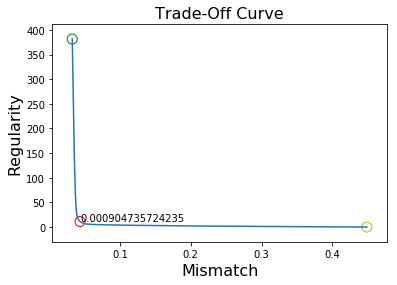

In [5]:
data_error = [res[2] for res in results if res is not None]
reg_error = [res[3] for res in results if res is not None]
lvals = [res[4] for res in results if res is not None]

l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
            (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
best = np.argsort(l_curve_distances)[-1]

plt.plot( data_error, reg_error)
plt.scatter(data_error[best],reg_error[best],s=100, facecolors='none', edgecolors='r')
plt.scatter(data_error[0],reg_error[0],s=100, facecolors='none', edgecolors='g')
plt.scatter(data_error[-1],reg_error[-1],s=100, facecolors='none', edgecolors='y')

plt.xlabel("Mismatch", fontsize=16)
plt.ylabel("Regularity", fontsize=16)
plt.title('Trade-Off Curve', fontsize=16)
plt.text(data_error[best],reg_error[best],lvals[best])

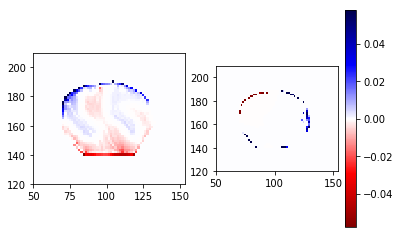

In [11]:
x_min = min(coords[boundary == 1, 0])
x_max = max(coords[boundary == 1, 0])
y_min = min(coords[boundary == 1, 1])
y_max = max(coords[boundary == 1, 1])
plt.subplot(121)
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
Fx = results[best][0][:,0]
Fy = results[best][0][:,1]
maxmagnitude = np.max(np.abs(Fx))

plt.pcolormesh(x_obs_positions,y_obs_positions,Fx.reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                           cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')
plt.subplot(122)
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
plt.pcolormesh(x_obs_positions,y_obs_positions,Fy.reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                           cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')
plt.colorbar()

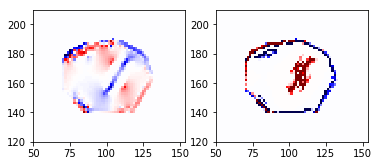

In [14]:
x_min = min(coords[boundary == 1, 0])
x_max = max(coords[boundary == 1, 0])
y_min = min(coords[boundary == 1, 1])
y_max = max(coords[boundary == 1, 1])
plt.subplot(121)
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
Fx = results[0][0][:,0]
Fy = results[0][0][:,1]
maxmagnitude = np.max(np.abs(Fx))

plt.pcolormesh(x_obs_positions,y_obs_positions,Fx.reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                           cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')
plt.subplot(122)
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
plt.pcolormesh(x_obs_positions,y_obs_positions,Fy.reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                           cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')
#plt.colorbar()

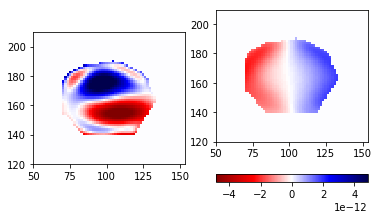

In [16]:
x_min = min(coords[boundary == 1, 0])
x_max = max(coords[boundary == 1, 0])
y_min = min(coords[boundary == 1, 1])
y_max = max(coords[boundary == 1, 1])
plt.subplot(121)
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
Fx = results[-1][0][:,0]
Fy = results[-1][0][:,1]
maxmagnitude = np.max(np.abs(Fx))

plt.pcolormesh(x_obs_positions,y_obs_positions,Fx.reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                           cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')
plt.subplot(122)
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
plt.pcolormesh(x_obs_positions,y_obs_positions,Fy.reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                           cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')
plt.colorbar(orientation='horizontal')

In [9]:
import pickle
import gzip

with gzip.open('results/isotropic_L1_results.gz','wb') as f:
    pickle.dump(results + [[x_obs_positions,y_obs_positions]] ,f)
    


In [10]:
len(results)

24